# Sentinel-1 Land Change Notebook
<br>
This notebook uses Sentinel-1 data to detect land change. These changes could be related to agriculture, deforestation, flooding, urbanization, or other factors. This notebook includes several different data products including histograms, a single-date single-band threshold product, and a multi-date land change product.
<br><br>
The core data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction (RTC) so there are issues using this data in mountaineous areas. In addition, users are recommended to only compare scenes from the same pass direction (ascending or descending) and orbit path to avoid viewing geometry issues. 
<br><br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for "MODIFY HERE" labels at the top of several code blocks to identify code that can be modified. For example, users can select a new analysis region, time extent, speckle filter size, the date used for the histogram plot, the date used for the single-band threshold water plot, and the dates used for the multi-date threshold flooding plot. Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

## Load the Data Cube Configuration and Import Utilities

In [1]:
# Ignore warnings 
#import warnings
#warnings.simplefilter('ignore')

# Load Data Cube Configuration
import datacube
dc = datacube.Datacube()

# Import Utilities
from datacube.utils import masking
from dea_tools.plotting import rgb, display_map
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

### EASI tools
import sys, os
sys.path.append(os.path.expanduser('../scripts'))
os.environ['USE_PYGEOS'] = '0'
from easi_tools import EasiDefaults
from easi_tools import notebook_utils
easi = EasiDefaults() # Get the default parameters for this system

Successfully found configuration for deployment "eail"


In [2]:
# Select a Product and Platform
product = "s1_rtc"

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the sample regions or add a new region. Use the map below to zoom in-or-out to find other regions. Click on the map to view a Lat-Lon position. After selecting an analysis region, you can also select a time window by defining the start date and end date for the "time_extents" parameter.

In [3]:
# MODIFY HERE

# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)

# Camp Fire, Paradise, CA
# Time = 2018-10-01, 2018-11-30
# Fire started 11-08, contained 11-25
# Data Filter > Orbit=137

# lat_long = (39.76, -121.550)
# box_size_deg = 0.25
# time_extents = ('2018-10-01', '2018-12-31')

# Lake Berryessa, Napa, CA
# Time = 2020-07-01, 2020-09-01
# Fire started 08-16-20
# Data Filter > Orbit=35

# lat_long = (38.5, -122.228)
# box_size_deg = 0.10
# time_extents = ('2020-07-01', '2020-09-01')

# Sample Fire Region from Jack
# Time = 2020-02-04
# Data Filter > Orbit=147

# lat_long = (-35.625, 148.920)
# box_size_deg = 0.40
time_extents = ('2019-01-01', '2019-03-01')

In [4]:
# Calculate the latitude and longitude bounds of the analysis box
# latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
# longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)
latitude = easi.latitude
longitude = easi.longitude

In [5]:
display_map(longitude,latitude)

## Define Filtering, Load the Data and View the Available Dates
This is where the Sentinel-1 data is loaded with specific filtering parameters. Due to the lack of Radiometric Terrain Correction (RTC), In addition, users are recommended to only compare scenes from the same pass direction (ascending or descending) and orbit path to avoid viewing geometry issues. 


it is advised that one consistent orbit pass direction is used (e.g. ASCENDING or DESCENDING). This will ensure the viewing angles are consistent for a given location and avoid false land change detection. By experimenting with the choice of either pass direction it may be possible to maximize the available dates for analyses.

In [6]:
parameters = dict(product=product, measurements=['vv','vh'],
                  time=time_extents, lat=latitude, lon=longitude, group_by='time',
                 )
                  # query={'filter':'relativeOrbitNumber_start=147'})

In [7]:
sar_dataset = dc.load(**parameters)
sar_dataset

<xarray.Dataset>
Dimensions:      (time: 4, latitude: 500, longitude: 500)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-12T23:06:28.500000 ... 2019-03...
  * latitude     (latitude) float64 37.12 37.12 37.12 ... 37.02 37.02 37.02
  * longitude    (longitude) float64 -76.55 -76.55 -76.55 ... -76.45 -76.45
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.05571 0.05571 ... 0.4879
    vh           (time, latitude, longitude) float32 0.03644 0.03644 ... 0.2986
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [8]:
from operator import itemgetter

def get_metadata(group):
    metadata = (set(), set(), set(), set())
    for ds in group:
        metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))
        metadata[1].add(ds.metadata_doc.get('properties').get('sentinel:orbit'))
        metadata[2].add(ds.metadata_doc.get('properties').get('eo:platform'))
        metadata[3].add(ds.metadata_doc.get('properties').get('sentinel:datatake_id'))
    return tuple(map(lambda x: ', '.join([str(i) for i in x]), metadata))

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],key=itemgetter(0))

/tmp/ipykernel_2380/2860363567.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))


In [9]:
# Show acquisition indices and dates
pd.set_option('display.max_rows', 250)
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Orbit', 'Platform', 'ID'])

,Acquisition Date,Orbit,Platform,ID
0,2019-01-12,025451,sentinel1,02D1EA
1,2019-01-24,025626,sentinel1,02D84E
2,2019-02-17,025976,sentinel1,02E4D4
3,2019-03-01,026151,sentinel1,02EB1A


### Speckle Filtering using a Block Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block" filter to average the pixels surrounding any given pixel. Users can select an odd number "filter_size" (e.g. 3,5,7, etc.) to filter both the VV and VH data. 

In [10]:
# Setup dB to power conversion functions so that filters work on power values

def to_pwr(x):
    return 10**(x/10)
def to_db(x):
    return 10*np.log10(x)

In [11]:
# MODIFY HERE

# Users can select the "filter_size" to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 

from ceos_utils.data_cube_utilities.raster_filter import stats_filter_2d

# Set any null values to 0 before applying the filter to prevent issues
sar_dataset_filled = sar_dataset.where(~sar_dataset.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
sar_dataset["block_filter_vv"] = sar_dataset_filled.vv.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)
sar_dataset["block_filter_vh"] = sar_dataset_filled.vh.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)

## View Histogram Plots
Histogram plots are good for viewing the statistics of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). The VH histogram below will typically show land at a peak of -15 dB and water at a peak of -27 dB. A reasonable threshold for water detection may be estimated from this histogram. For example, one may select a threshold of -20 dB for the water and land separation.

In [12]:
# MODIFY HERE

# Choose a single time slice by its index (listed above)
acq_ind_to_show = 2

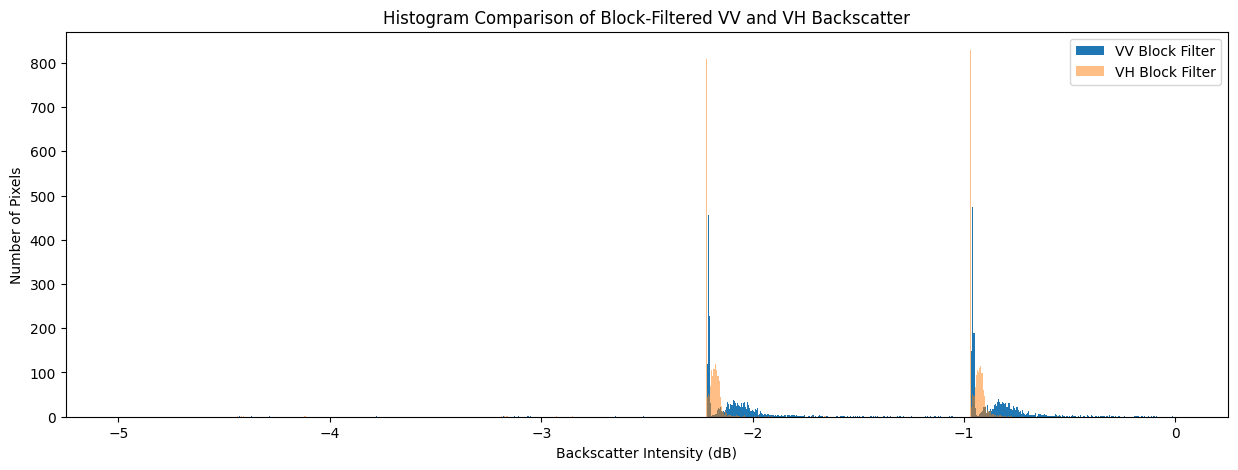

In [13]:
fig = plt.figure(figsize=(15, 5))
sar_dataset.isel(time=acq_ind_to_show).block_filter_vv.plot.hist(bins=1000, range=(-5,0), 
                                                                 label="VV Block Filter")
sar_dataset.isel(time=acq_ind_to_show).block_filter_vh.plot.hist(bins=1000, range=(-5,0), 
                                                                 label="VH Block Filter", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of Block-Filtered VV and VH Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) is converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [14]:
# This backscatter scaling is optimized for block-filtered data
# VV band range is 0dB to -16dB which is DN=1.00 to DN=0.158
# VH band range is -5dB to -27dB which is DN=0.562 to DN=0.045
# VV/VH range is 0.0 to 1.0. This data is scaled by 20 for improved color contrast

vv_convert = (10**(sar_dataset.block_filter_vv/20)-0.158)*303
vh_convert = (10**(sar_dataset.block_filter_vh/20)-0.045)*493
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 20
sar_dataset['vvvh'] = (sar_dataset.vv / sar_dataset.vh) * 20

## VV, VH and RGB images

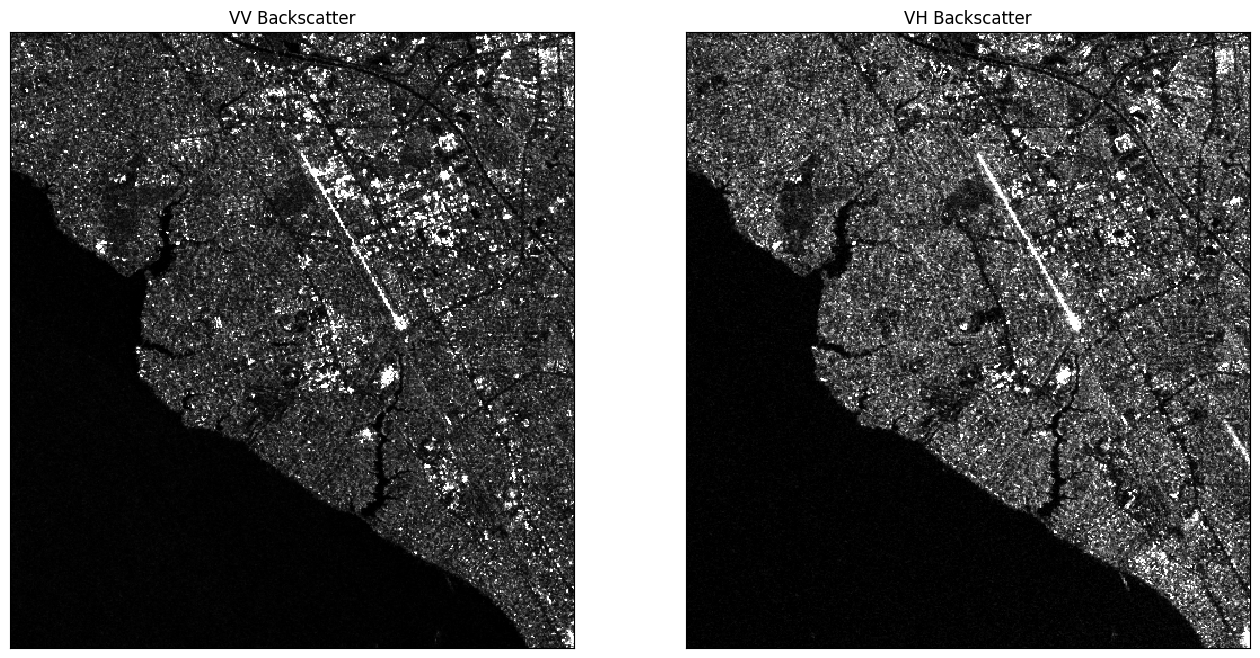

In [15]:
# Plots of VV and VH Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sar_dataset['r1'] = sar_dataset.vv
sar_dataset['b1'] = sar_dataset.vv
sar_dataset['g1'] = sar_dataset.vv
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[0], bands=['r1','g1','b1'])
sar_dataset['r2'] = sar_dataset.vh
sar_dataset['b2'] = sar_dataset.vh
sar_dataset['g2'] = sar_dataset.vh
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[1], bands=['r2','g2','b2'])
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

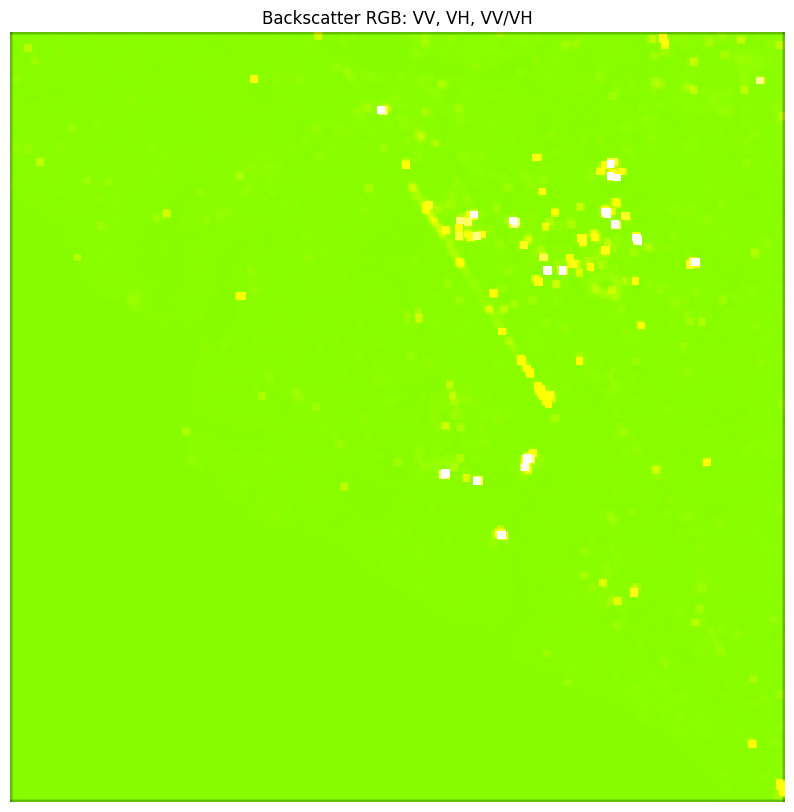

In [16]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is BLACK (low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=acq_ind_to_show),bands=['vv_amp','vh_amp','vvvh_amp'], size=10, robust=True)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Multi-Date RGB Land Change Product

In [17]:
# Define a custom RGB - This custom RGB allows specific bands and time slices to be assigned to each color
# This custom RGB can be valuable for viewing land changes between two time periods

def custom_rgb(dataset, rgb_to_data_arr_ind_map, **rgb_kwargs):
    rgb_data = {}
    for channel, [data_var, time_ind] in zip(['nbart_red', 'nbart_green', 'nbart_blue'], rgb_to_data_arr_ind_map):
        rgb_data[channel] = dataset[data_var].isel(time=time_ind)
        rgb_data[channel] = rgb_data[channel].drop('time').to_array()
    rgb_data = xr.Dataset(rgb_data).squeeze('variable')
    rgb_kwargs['ds'] = rgb_data
    rgb(**rgb_kwargs)
    return fig, ax

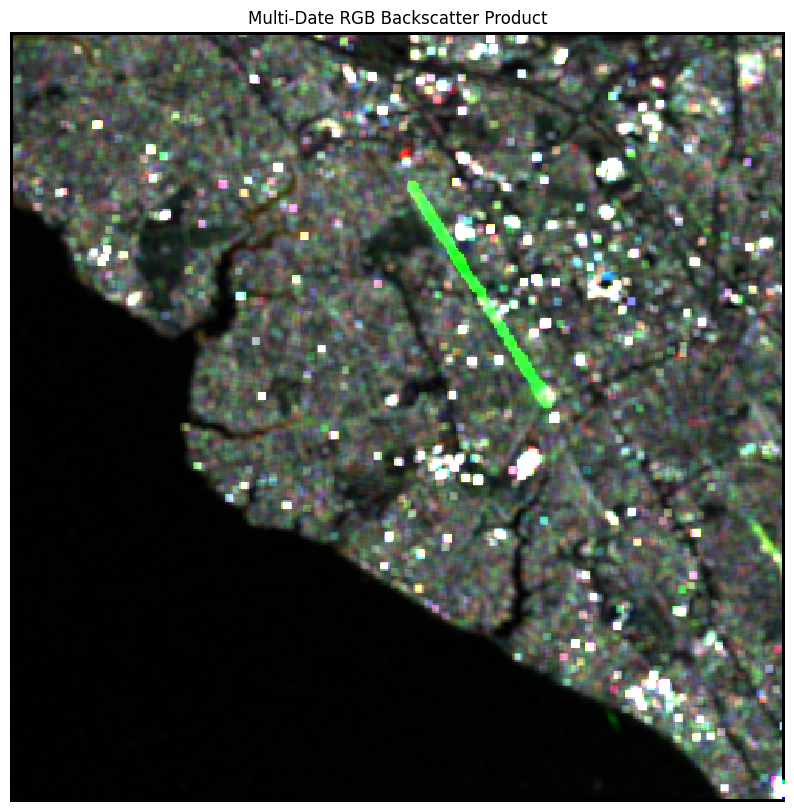

In [18]:
# MODIFY HERE

# Define a custom RGB image using multiple dates and bands
# This product can be useful to view land change between different time periods

# Select the band: 'vv_amp' or 'vh_amp'
band = ['vh_amp']

# Selent the scene index for each color: Red, Green, Blue
first_scene = 0   # This is the RED color
second_scene = 2  # This is the GREEN color
third_scene = 3   # This is the BLUE color

# Color Interpretation for output results
# Red areas have high vegetation (cropping) at the early date
# Green areas have high vegetation (cropping) at the middle date
# Blue areas have high vegetation (cropping) at the later date
# Cyan (mix of green and blue) have higher vegetation in 2nd and 3rd dates compared to 1st date
# Magenta (mix of red and blue) have higher vegetation in 1st and 3rd dates compared to 2nd date
# Yellow (mix of red and green) have higher vegetation in 1st and 2nd dates compared to 3rd date
# Grey regions are high scattering (all dates) due to tree foliage or grass vegetation
# Black regions are low scattering (all dates) due to water or low vegetation (bare soils)

rgb_to_data_arr_ind_map = [[band,first_scene],[band,second_scene],[band,third_scene]]
custom_rgb(sar_dataset, rgb_to_data_arr_ind_map, size=10)
plt.title('Multi-Date RGB Backscatter Product')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Land Change Product
The code below selects two dates, a variable (VV or VH) and a threshold range. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding. Pixels with significant increases in backscatter (e.g., increase of 7 dB) are likely changes from water to land due to drying or drought.

In [19]:
# MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 1
second_acq_ind = 3

# Select the variable to plot: vv or vh

threshold_variable = 'block_filter_vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range

threshold_range = (-4, 8)

In [20]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]

below_th = change_product.values < threshold_range[0]
above_th = threshold_range[1] < change_product.values

In [21]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels and not show false change

water = first_acq[threshold_variable].values < -21.0

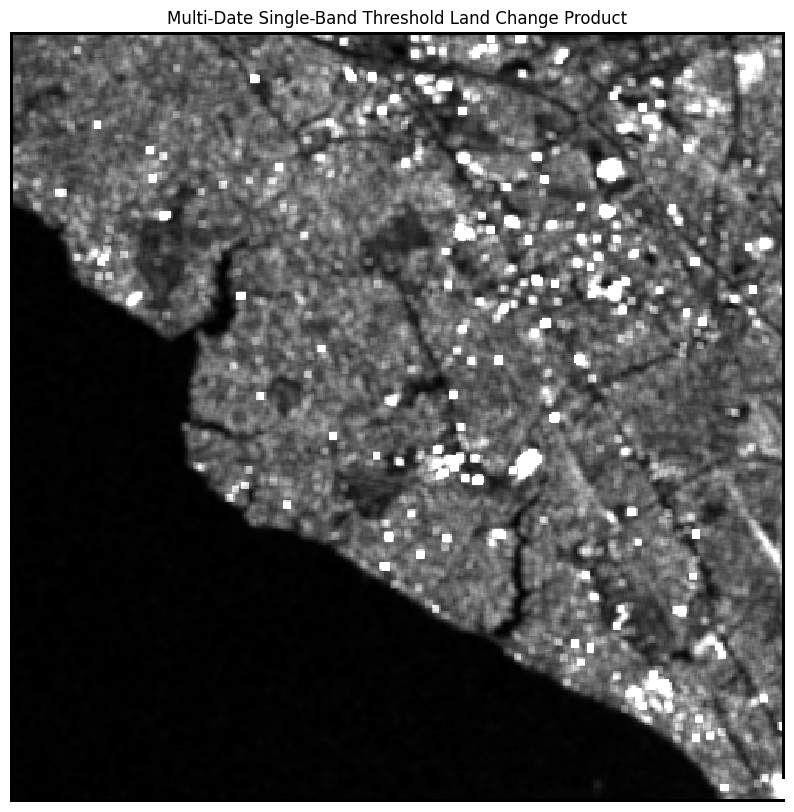

In [22]:
# Create a custom threshold plot to identify land change
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter or a loss of vegetation
# GREEN areas have increased backscatter or an increase in vegetation
# BLACK areas have no significant backscatter change or are water

first_acq['red'] = first_acq.block_filter_vh
first_acq['green'] = first_acq.block_filter_vh
first_acq['blue'] = first_acq.block_filter_vh

rgb(first_acq, bands=['red', 'green', 'blue'], size=10)
    # paint_on_mask=[(below_th, color_loss),(above_th, color_gain),(water, color_black)])
plt.title('Multi-Date Single-Band Threshold Land Change Product')
plt.axis('off')
plt.show()